In [1]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 20 21:21:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

from torch.optim import Adam
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from drive.MyDrive.DLSC.projectB.Common import NeuralNet

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Data Loading

In [27]:
def t_to_string(t, N, dim):
    str_t = "{:.3f}".format(t)
    str_t = str_t.replace(".", "_")
    str_t = str_t.zfill(6)
    str_N = str(N).zfill(4)  # Assumes N is less than 10,000
    str_dim = str(dim)
    return str_t + "_" + str_N + "_" + str_dim

T = 0.1
N_dataSamples = 1000
d = 3
n_points = 50
path = '/content/drive/MyDrive/DLSC/projectB/heat/'

t_string = t_to_string(T, N_dataSamples, d)

# Load the numpy arrays (path = '/content/drive/MyDrive/projectB/heat/')
inputs_parametric_np = np.load(path + f'inputs_parametric_heat_{t_string}.npy')
outputs_parametric_np = np.load(path + f'outputs_parametric_heat_{t_string}.npy')

# Convert to tensors
inputs_parametric_tensor = torch.tensor(inputs_parametric_np).type(torch.float32).to(device)
outputs_parametric_tensor = torch.tensor(outputs_parametric_np).type(torch.float32).to(device)

print(inputs_parametric_tensor.shape)
print(outputs_parametric_tensor.shape)

torch.Size([2500000, 5])
torch.Size([2500000])


In [28]:
batch_size = 5000
torch.manual_seed(42)

# Split the data into a training, validation and test set 80-20 split, important don't shuffle (data structure)
train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(inputs_parametric_tensor, outputs_parametric_tensor, test_size=0.2, shuffle=False)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(temp_inputs, temp_outputs, test_size=0.5, shuffle=False)

# Create DataLoaders
training_set = DataLoader(TensorDataset(train_inputs, train_outputs), batch_size=batch_size, shuffle=True)
validation_set = DataLoader(TensorDataset(val_inputs, val_outputs), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(test_inputs, test_outputs), batch_size=n_points*n_points, shuffle=False)

### Network parameters

In [29]:
# Define the network parameters
network_params = {
    "input_dimension": 2 + d,
    "output_dimension": 1,
    "n_hidden_layers": 3,
    "neurons": 62,
    "regularization_param": 0.00,
    "regularization_exp": 0,
    "retrain_seed": 42
}

# Training Parameter
learning_rate = 2e-3
epochs = 100
step_size = 20
gamma = 0.5
patience = 100
best_loss = np.inf
best_epoch = 0
save_path = path + f'parametric_heat_{t_string}_epochs_{epochs}.pt'


# Instantiate the network
net = NeuralNet(**network_params)
net = net.to(device)

# # Load the model
# net.load_state_dict(torch.load('/content/drive/MyDrive/DLSC/projectB/heat/parametric_heat_00_100_1000_2_epochs_100.pt'))



# Count parameters
pytorch_total_params_parametric = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("number of trainable parameters:", pytorch_total_params_parametric)

num_weights = (network_params['n_hidden_layers'] - 1) * (network_params['neurons'] + 1)*network_params['neurons'] + (network_params['input_dimension']+1)*network_params['neurons'] + (network_params['neurons']+1)
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("number of degrees of freedom:", num_weights, pytorch_total_params)

number of trainable parameters: 8247
number of degrees of freedom: 8247 8247


In [26]:
# Optimize for parameter
import scipy.optimize as optimize

def equation(Nneurons, d, Nlayers, SNN):
    return (2 + d + 1) * Nneurons + (Nlayers - 1) * (Nneurons + 1) * Nneurons + (Nneurons + 1) - SNN

def approximate_Nneurons(d, Nlayers, SNN):
    result = optimize.root_scalar(equation, method='brentq', bracket=[1, 10000], args=(d, Nlayers, SNN))
    approximate_Nneurons = round(result.root)
    return approximate_Nneurons

# Specify the values for additional variables
d_value = 2
Nlayers_value = 3
SNN_value = 8197

# Approximate the value of Nneurons for the given parameters
approximate_Nneurons_value = approximate_Nneurons(d_value, Nlayers_value, SNN_value)
print("Approximate value of Nneurons:", approximate_Nneurons_value)


Approximate value of Nneurons: 62


### Training

In [ ]:

# Define the optimizer and loss function
optimizer = Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
l = torch.nn.MSELoss()
freq_print = 1

train_errors = []
val_errors = []
start_time = time.time()
for epoch in range(epochs):
    train_loss = 0.0
    # forward pass
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = net(input_batch).squeeze()
        loss_f = l(output_pred_batch, output_batch)
        #loss_f += net.regularization()
        loss_f.backward()
        optimizer.step()
        train_loss += loss_f.item()

    train_loss /= len(training_set)
    train_errors.append(train_loss)


    scheduler.step()

    # validation loop
    with torch.no_grad():
        net.eval()
        val_loss = 0.0
        for step, (input_batch, output_batch) in enumerate(validation_set):

            output_pred_batch = net(input_batch).squeeze()
            # loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            loss_f = torch.sqrt(torch.mean((output_pred_batch - output_batch) ** 2))
            val_loss += loss_f.item()
        val_loss /= len(validation_set)
        val_errors.append(val_loss)


    # early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        torch.save(net.state_dict(), save_path)  # Save the model

    elif (epoch - best_epoch) >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % freq_print == 0:
        print("######### Epoch:", epoch, " ######### Train Loss:", train_loss,
              " ######### Validation Loss:", val_loss)

# Training time
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time} seconds")
print(f"Training complete. Best validation loss: {best_loss} at epoch {best_epoch}")


######### Epoch: 0  ######### Train Loss: 0.013113337681279518  ######### Validation Loss: 0.023318660855293275
######### Epoch: 1  ######### Train Loss: 0.00043570356036070734  ######### Validation Loss: 0.018046770188957454
######### Epoch: 2  ######### Train Loss: 0.00031714758362795693  ######### Validation Loss: 0.01630271234549582
######### Epoch: 3  ######### Train Loss: 0.0003064010151865659  ######### Validation Loss: 0.01601467974483967
######### Epoch: 4  ######### Train Loss: 0.0003336225653038127  ######### Validation Loss: 0.02518936101347208
######### Epoch: 5  ######### Train Loss: 0.00032923919174209003  ######### Validation Loss: 0.02562589183449745
######### Epoch: 6  ######### Train Loss: 0.00031928130170854273  ######### Validation Loss: 0.019616544656455518
######### Epoch: 7  ######### Train Loss: 0.0003414092378443456  ######### Validation Loss: 0.01305182701908052
######### Epoch: 8  ######### Train Loss: 0.0002916956366607337  ######### Validation Loss: 0.0140

In [25]:
import os

# save the errors for plotting
path_errors = '/content/drive/MyDrive/DLSC/projectB/heat/errors/'


# Define the filename using an f-string
train_errors_filename = os.path.join(path_errors, f'train_errors_parametric_{t_string}.npy')
val_errors_filename = os.path.join(path_errors, f'val_errors_parametric_{t_string}.npy')

# Save the errors as numpy arrays
np.save(train_errors_filename, train_errors)
np.save(val_errors_filename, val_errors)

NameError: ignored

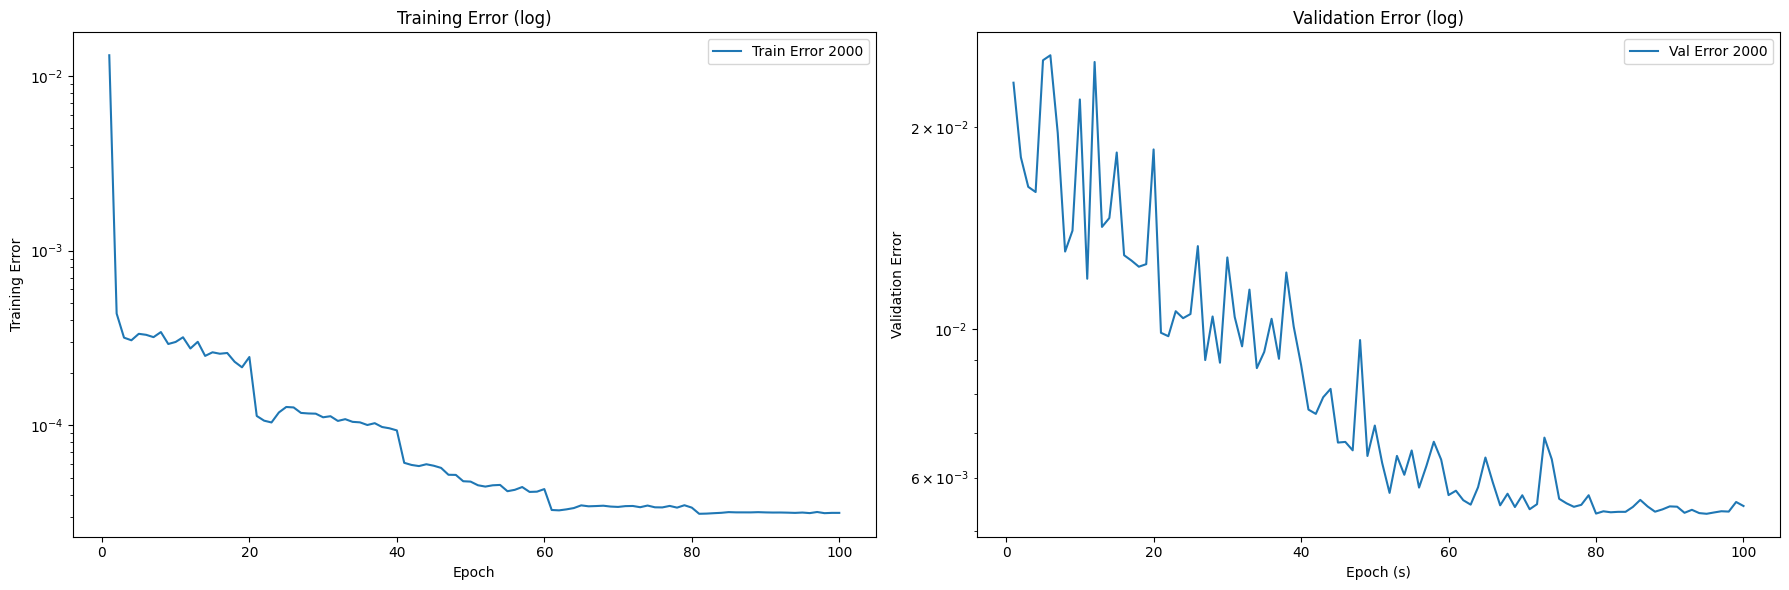

In [ ]:

# Load the data
train_errors2000 = np.load(os.path.join(path_errors, f'train_errors_parametric_{t_string}.npy'))
val_errors2000 = np.load(os.path.join(path_errors, f'val_errors_parametric_{t_string}.npy'))

# train_errors5000 = np.load(os.path.join(path, f'train_errors_parametric{t_string}_5000Batch.npy'))
# val_errors5000 = np.load(os.path.join(path, f'val_errors_parametric{t_string}_5000Batch.npy'))

# # Suppose we have third set of data
# train_errors7000 = np.load(os.path.join(path, f'train_errors_parametric{t_string}_2048Batch.npy'))
# val_errors7000 = np.load(os.path.join(path, f'val_errors_parametric{t_string}_2048Batch.npy'))

# Create a figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the training error
axes[0].plot(np.arange(len(train_errors2000)) + 1, train_errors2000, label='Train Error 2000')
#axes[0].plot(np.arange(len(train_errors5000)) + 1, train_errors5000, label='Train Error 5000')
#axes[0].plot(np.arange(len(train_errors7000)) + 1, train_errors7000, label='Train Error 7000')  # New line to plot third data
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Error')
axes[0].set_title('Training Error (log)')
axes[0].legend()

# Plot the validation error
axes[1].plot(np.arange(len(val_errors2000)) + 1, val_errors2000, label='Val Error 2000')
#axes[1].plot(np.arange(len(val_errors5000)) + 1, val_errors5000, label='Val Error 5000')
#axes[1].plot(np.arange(len(val_errors7000)) + 1, val_errors7000, label='Val Error 7000')  # New line to plot third data
axes[1].set_xlabel('Epoch (s)')
axes[1].set_yscale('log')
axes[1].set_ylabel('Validation Error')
axes[1].set_title('Validation Error (log)')
axes[1].legend()


# Adjust the spacing between subplots
plt.tight_layout()
plt.show()


### Evaluation

In [30]:
#  Evaluate on the test set (Load the best model)
net.load_state_dict(torch.load(save_path))
net.eval()

# store all predictions and actual outputs
output_pred_all = []
output_test_all = []
n_points = 50

# Iterate over all batches in the test set
start_time = time.time()
for input_batch, output_batch in testing_set:

    # Predict the output for the entire batch at once
    output_pred_batch = net(input_batch).cpu().detach().numpy()

    # Store the predictions and actual outputs
    output_pred_all.extend(output_pred_batch)
    output_test_all.extend(output_batch.cpu().numpy())

# Convert the lists to arrays
output_pred_all = np.array(output_pred_all)
output_test_all = np.array(output_test_all)

# Reshape the output back into a 2D grid
output_pred_2D = output_pred_all.reshape(-1, n_points, n_points)
output_test_2D = output_test_all.reshape(-1, n_points, n_points)

# Calculate the total test error
total_test_error = np.mean((output_pred_2D - output_test_2D) ** 2)
log_total_test_error = np.log(total_test_error)

end_time = time.time()
prediction_time = end_time - start_time
print(f"Total prediction time: {prediction_time} seconds")

print(f"Total Test Error (MSE): {total_test_error}")
print(f"Total Test Error Log (MSE): {log_total_test_error}")


Total prediction time: 2.494581937789917 seconds
Total Test Error (MSE): 1.3486696843756363e-05
Total Test Error Log (MSE): -11.213807106018066


In [31]:

# Approach to calcualte the relative error

#  Evaluate on the test set (Load the best model)
net.load_state_dict(torch.load(save_path))
net.eval()

# store all predictions and actual outputs
output_pred_all = []
output_test_all = []
n_points = 50

# Iterate over all batches in the test set
start_time = time.time()
for input_batch, output_batch in testing_set:

    # Predict the output for the entire batch at once
    output_pred_batch = net(input_batch).cpu().detach().numpy()

    # Store the predictions and actual outputs
    output_pred_all.extend(output_pred_batch)
    output_test_all.extend(output_batch.cpu().numpy())

# Convert the lists to arrays
output_pred_all = np.array(output_pred_all)
output_test_all = np.array(output_test_all)

# Reshape the output back into a 2D grid
output_pred_2D = output_pred_all.reshape(-1, n_points, n_points)
output_test_2D = output_test_all.reshape(-1, n_points, n_points)

# Calculate the total test error
total_test_error = np.mean((output_pred_2D - output_test_2D) ** 2)
log_total_test_error = np.log(total_test_error)

# Calculate the total variance
total_variance = np.var(output_test_all)

# Calculate the relative test error
relative_test_error = total_test_error / total_variance
log_relative_test_error = np.log(relative_test_error)

end_time = time.time()
prediction_time = end_time - start_time
print(f"Total prediction time: {prediction_time} seconds")

print(f"Total Test Error (MSE): {total_test_error}")
print(f"Total Test Error Log (MSE): {log_total_test_error}")

print(f"Relative Test Error: {relative_test_error}")
print(f"Log of Relative Test Error: {log_relative_test_error}")


Total prediction time: 2.3799984455108643 seconds
Total Test Error (MSE): 1.3486696843756363e-05
Total Test Error Log (MSE): -11.213807106018066
Relative Test Error: 0.010268895886838436
Log of Relative Test Error: -4.5786356925964355


### Plotting

<Figure size 2000x600 with 0 Axes>

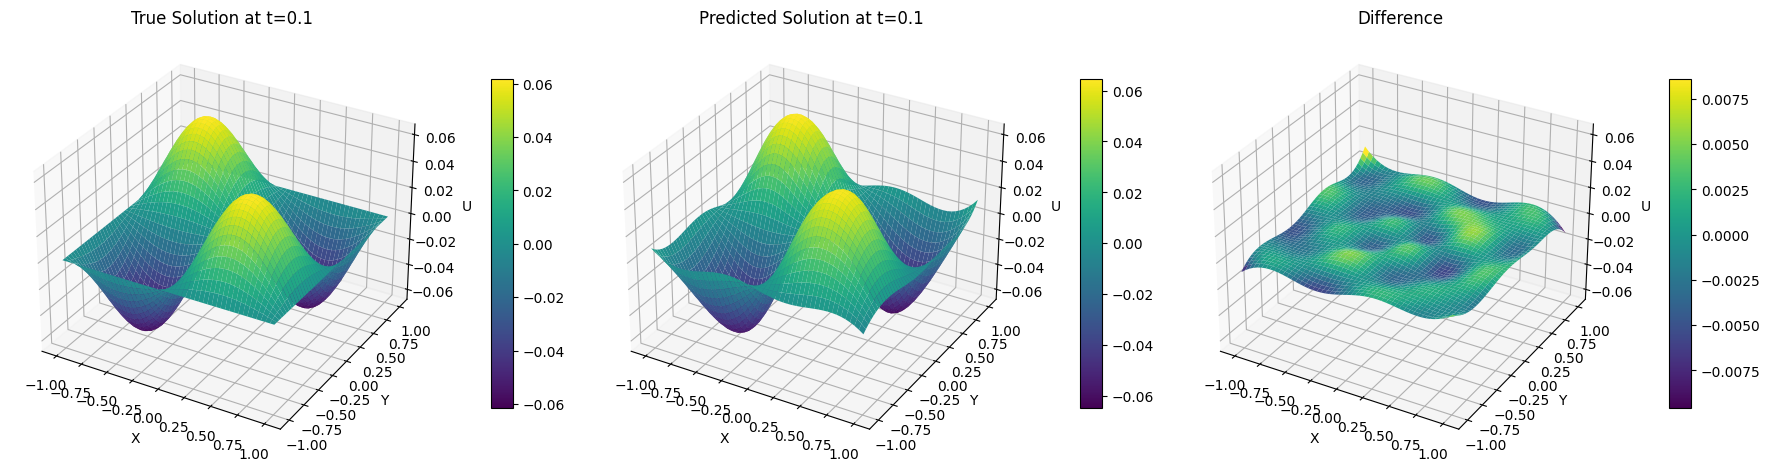

<Figure size 640x480 with 0 Axes>

In [9]:
net.load_state_dict(torch.load(save_path))

# Define the domain
x1 = np.linspace(-1, 1, n_points)
x2 = np.linspace(-1, 1, n_points)
X, Y = np.meshgrid(x1, x2)

# Create a single figure
fig = plt.figure(figsize=(20, 6))

sample_index = 3  # For example, to select the second sample

start_index = sample_index * n_points ** 2
end_index = (sample_index + 1) * n_points ** 2

# Collect all the predictions for a complete 2D grid
output_pred_all = []
output_test_all = []
for i in range(start_index, end_index):
    input_test = test_inputs[i, :].unsqueeze(0)
    output_test = test_outputs[i]
    output_pred = net(input_test).detach().cpu().numpy()
    output_pred_all.append(output_pred)
    output_test_all.append(output_test.cpu().numpy())

# Reshape the output back into a 2D grid
output_pred_2D = np.array(output_pred_all).reshape(n_points, n_points)
output_test_2D = np.array(output_test_all).reshape(n_points, n_points)

# Compute difference
difference_2D = output_test_2D - output_pred_2D

# Compute the range for the z-axis
z_min = min(np.min(output_test_2D), np.min(output_pred_2D))
z_max = max(np.max(output_test_2D), np.max(output_pred_2D))
z_range = max(abs(z_min), abs(z_max))
fig = plt.figure(figsize=(18, 5))

# Plot the true solution
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, output_test_2D, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('U')
ax1.set_title('True Solution at t=0.1')
ax1.set_zlim([-z_range, z_range])
fig.colorbar(surf1, ax=ax1, shrink=0.7, aspect=15, pad=0.1)

# Plot the predicted solution
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, output_pred_2D , cmap='viridis')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('U')
ax2.set_title('Predicted Solution at t=0.1')
ax2.set_zlim([-z_range, z_range])
fig.colorbar(surf2, ax=ax2, shrink=0.7, aspect=15, pad=0.1)

# Plot the difference
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
surf3 = ax3.plot_surface(X, Y, difference_2D, cmap='viridis')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('U')
ax3.set_title('Difference')
ax3.set_zlim([-z_range, z_range])
fig.colorbar(surf3, ax=ax3, shrink=0.7, aspect=15, pad=0.1)

plt.tight_layout()
plt.show()



# # Plot the difference as a 2D heatmap
# ax = fig.add_subplot(1, 3, 3)
# heatmap = ax.imshow(difference_2D, cmap='viridis', origin='lower', extent=[-1, 1, -1, 1], vmin=-0.1, vmax=0.1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_title('Difference ')
# plt.colorbar(heatmap)
# fig.subplots_adjust(wspace=0.3)




plt.tight_layout(pad=1.0)
plt.show()


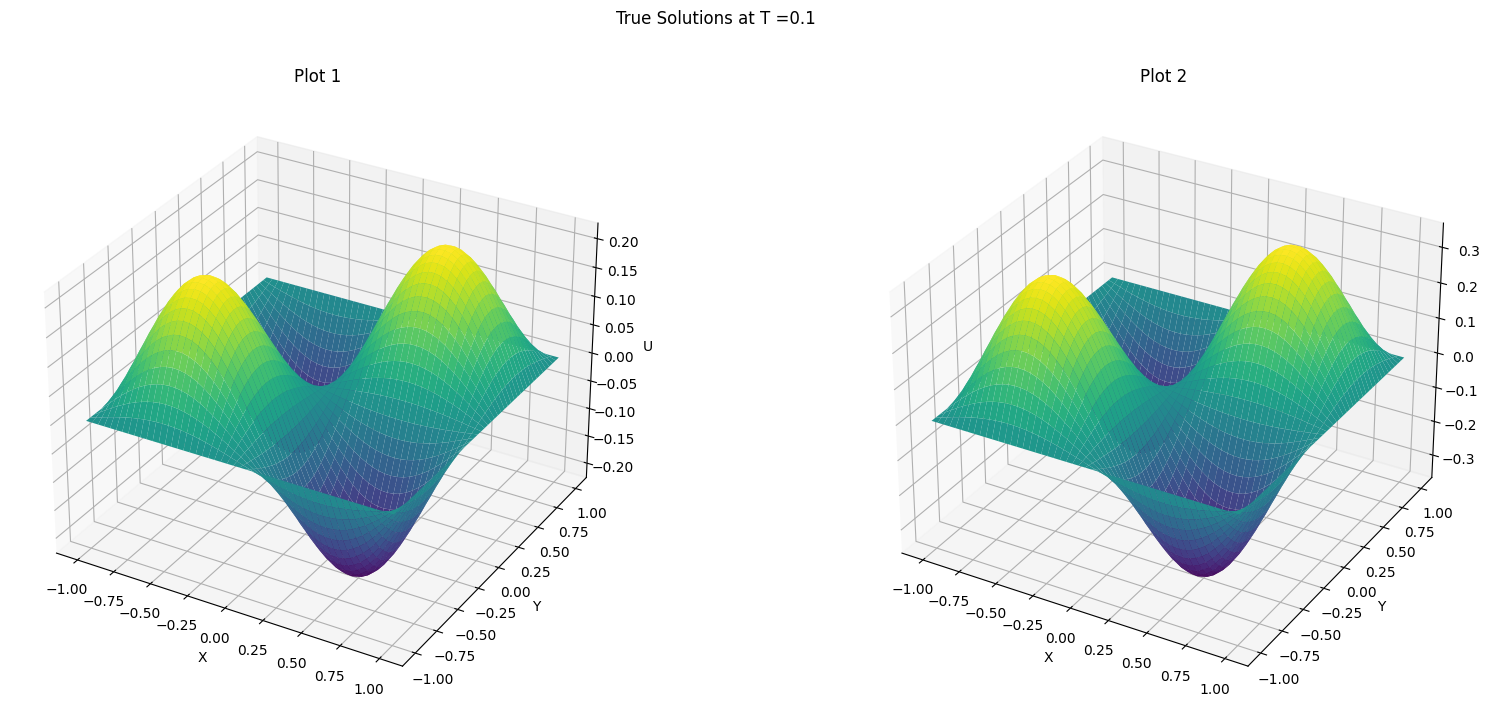

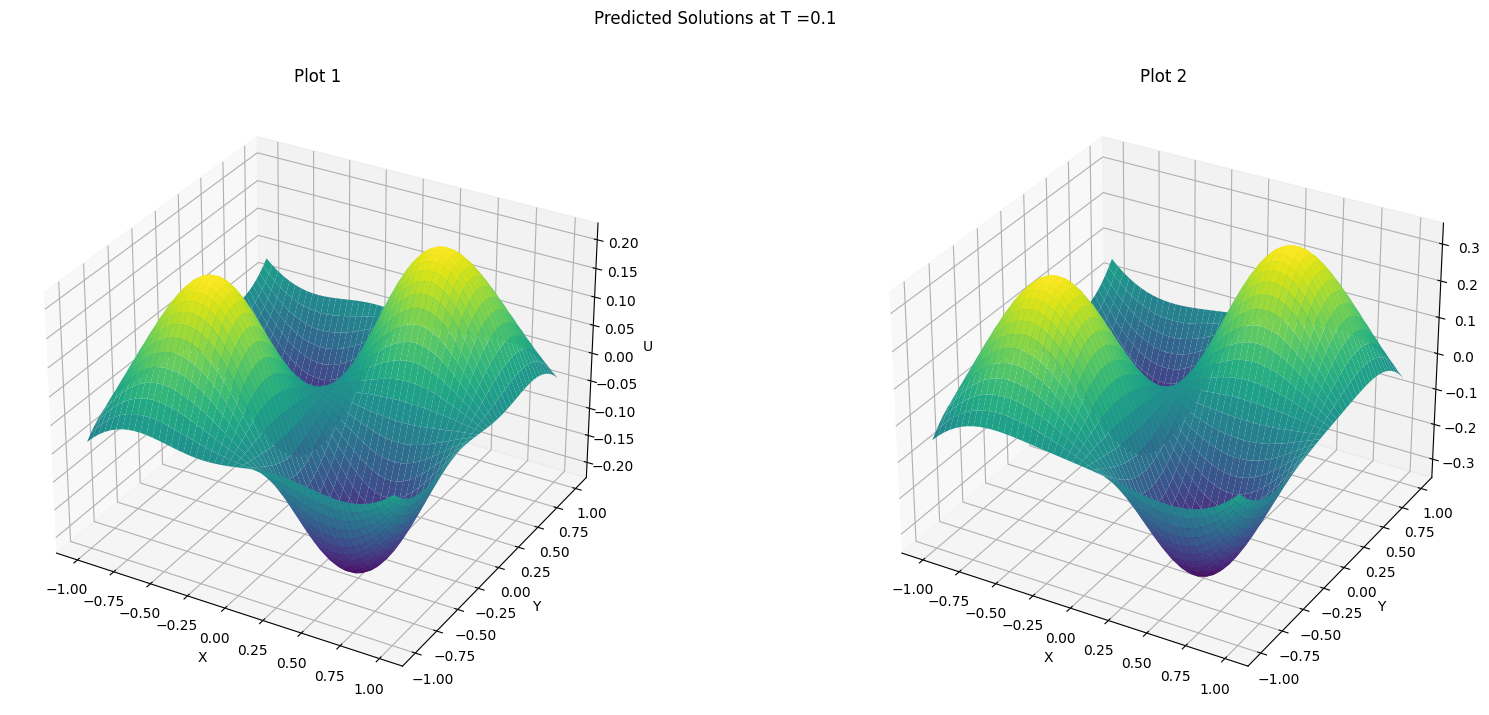

In [ ]:
# plot

net.load_state_dict(torch.load(save_path))
#mean_output_parametric = np.load(save_path + f'mean_output_parametric_heat_{t_string}.npy')
#std_output_parametric = np.load(save_path + f'heat/std_output_parametric_heat_{t_string}.npy')

n_plots = 2
n_rows = 1
n_cols = 2

# Define the domain
x1 = np.linspace(-1, 1, n_points)
x2 = np.linspace(-1, 1, n_points)
X, Y = np.meshgrid(x1, x2)

# Create two separate figures for true solutions and predicted solutions
fig1 = plt.figure(figsize=(20, 8))  # Adjust as needed
fig1.suptitle('True Solutions at T ={}'.format(T))
fig2 = plt.figure(figsize=(20, 8))  # Adjust as needed
fig2.suptitle('Predicted Solutions at T ={}'.format(T))

for plot_number in range(n_plots):
    start_index = plot_number * n_points ** 2
    end_index = (plot_number + 1) * n_points ** 2

    # Collect all the predictions for a complete 2D grid
    output_pred_all = []
    output_test_all = []
    for i in range(start_index, end_index):
        input_test = test_inputs[i, :].unsqueeze(0)
        output_test = test_outputs[i]
        output_pred = net(input_test).detach().cpu().numpy()
        # output_pred_denormalized = output_pred * std_output_parametric + mean_output_parametric
        output_pred_all.append(output_pred)
        output_test_all.append(output_test.cpu().numpy())

    # Reshape the output back into a 2D grid
    output_pred_2D = np.array(output_pred_all).reshape(n_points, n_points)
    output_test_2D = np.array(output_test_all).reshape(n_points, n_points)

    # Plot the true solution
    ax = fig1.add_subplot(n_rows, n_cols, plot_number+1, projection='3d')
    surf = ax.plot_surface(X, Y,  output_test_2D, cmap='viridis') # output_test_2D * std_output_parametric + mean_output_parametric, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    ax.set_title('Plot {}'.format(plot_number + 1))

    # Plot the predicted solution
    ax = fig2.add_subplot(n_rows, n_cols, plot_number+1, projection='3d')
    surf = ax.plot_surface(X, Y, output_pred_2D , cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    ax.set_title('Plot {}'.format(plot_number + 1))

#plt.tight_layout()
plt.show()


In [ ]:

# Switch to evaluation mode
net.eval()

n_points = 50

# Create DataLoaders for testing with batch_size 2500
testing_set = DataLoader(TensorDataset(test_inputs, test_outputs), batch_size=n_points*n_points, shuffle=False)


# If batch size is equal to the size of one sample
start_time = time.time()

mse_values = []

for input_batch, output_batch in testing_set:

    # Predict the output for the entire batch at once
    output_pred = net(input_batch).detach().cpu().numpy()

    # The output arrays are already in the shape of one sample
    output_actual = output_batch.cpu().numpy()

    # Calculate the test error for the sample
    mse = np.mean((output_pred - output_actual) ** 2)
    mse_values.append(mse)

# Calculate the total test error
total_test_error = np.mean(mse_values)
log_total_test_error = np.log(total_test_error)

end_time = time.time()
prediction_time = end_time - start_time
print(f"Total prediction time: {prediction_time} seconds")

print(f"Total Test Error (MSE): {total_test_error}")
print(f"Total Test Error Log (MSE): {log_total_test_error}")